#Compression Technique 1: Quantization (MLP)

In [1]:
!pip install tensorflow-model-optimization

#Importing Required Libraries
* Imporitng the required libraries and mounting the drive to train and evaluate the model

In [30]:
import numpy as np
import tensorflow as tf
import tensorflow_model_optimization as tfmot
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt

# Load the trained MLP model

In [19]:
model = load_model("/content/drive/MyDrive/PG-PROJECT/baseline_mlp_model.h5", compile=False)
X_test = np.load("/content/drive/MyDrive/PG-PROJECT/X_test.npy")
y_test = np.load("/content/drive/MyDrive/PG-PROJECT/y_test.npy")


# Define representative dataset generator

In [9]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
        yield [tf.cast(input_value, tf.float32)]


# Full integer quantization

In [10]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()


Saved artifact at '/tmp/tmprtn88uk6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 5), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  135314800884240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135312265993040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135312265997840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135312265997264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135312265998608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135312265996688: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


# Save quantized model

In [45]:
quantized_model_path = "/content/drive/MyDrive/PG-PROJECT/mlp_full_integer_quantized.tflite"
with open(quantized_model_path, "wb") as f:
    f.write(tflite_model)
print(" Full Integer Quantized MLP model saved.")

 Full Integer Quantized MLP model saved.


# Prepare input for TFLite inference

In [12]:
input_scale, input_zero_point = 1.0, 0  # Placeholder, will be updated from interpreter
X_int8 = None

# Load TFLite model and allocate tensors

In [13]:
interpreter = tf.lite.Interpreter(model_path=quantized_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


# Get quantization parameters

In [14]:
input_scale, input_zero_point = input_details[0]['quantization']
output_scale, output_zero_point = output_details[0]['quantization']


# Quantize input

In [15]:
X_int8 = ((X_train / input_scale) + input_zero_point).astype(np.int8)

# Run inferenc

In [43]:
y_pred = []
for i in range(len(X_int8)):
    input_data = X_int8[i:i+1]
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    output_float = (output_data.astype(np.float32) - output_zero_point) * output_scale
    y_pred.append(np.argmax(output_float))

y_pred = np.array(y_pred)


In [42]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#Evaluate using Keras

In [41]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f" Keras Evaluation - Accuracy: {acc:.4f}, Loss: {loss:.4f}")

 Keras Evaluation - Accuracy: 0.9845, Loss: 0.0564


# Predict and evaluate manually

In [40]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


# Accuracy via sklearn

In [38]:
acc_sklearn = accuracy_score(y_true_classes, y_pred_classes)
print(f"📊 Sklearn Accuracy: {acc_sklearn:.4f}")

📊 Sklearn Accuracy: 0.9845


# Confusion Matrix

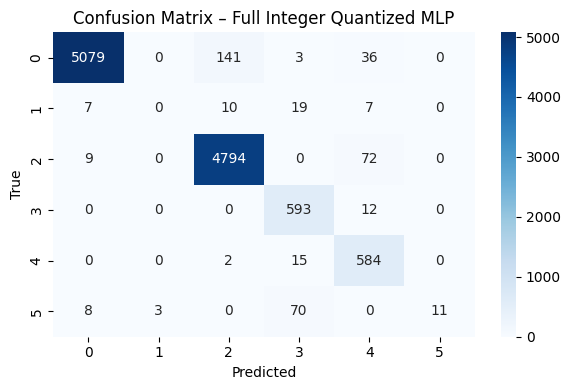

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      5259
           1       0.00      0.00      0.00        43
           2       0.97      0.98      0.98      4875
           3       0.85      0.98      0.91       605
           4       0.82      0.97      0.89       601
           5       1.00      0.12      0.21        92

    accuracy                           0.96     11475
   macro avg       0.77      0.67      0.66     11475
weighted avg       0.96      0.96      0.96     11475



In [44]:
# Confusion Matrix
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Full Integer Quantized MLP")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_train, y_pred))